## Threading, GIL

**1.** (2) Опишите в файле `threading_explained.md`, в чем разница между потоком и процессом.

**Процесс** - исполняемый экземпляр какой-либо программы. Каждый процесс состоит из следующих элементов:

- образ машинного кода;
- область памяти, в которую включается исполняемый код, данные процесса (входные и выходные данные), стек вызовов и куча (для хранения динамически создаваемых данных);
- дескрипторы операционной системы (например, файловые дескрипторы);
- состояние процесса.

В целях стабильности и безопасности, в современных операционных системы каждый процесс имеет прямой доступ только к своим собственным ресурсам.

Доступ к ресурсам другого процесса возможен через *межпроцессорное взаимодействие* (например, посредством файлов, при помощи именованных и неименованных каналов и другие).

Сам *процесс* может быть разделен на так называемые *потоки*.

**Поток** (поток выполнения, `thread`) - наименьшая единица обработки, исполнение которой может быть назначено ядром операционной системы. 

В отличие от нескольких процессов, потоки существуют внутри одного процесса и имеют доступ к ресурсам этого процесса. Каждый поток обладет собственным набором регистров и собственным стеком вызова, но доступ к ним имеют и другие потоки.

**2.** (2) Опишите в файле `gil.md`, что такое GIL и почему `multiprocessing` свободен от него.

**Global Interpreter Lock(GIL)** — это своеобразная блокировка, позволяющая только одному потоку управлять интерпретатором Python. Это означает, что в любой момент времени будет выполняться только один конкретный поток.

Чтобы обойти это «ограничение», мы используем модуль `multiprocessing`. Вместо использования потоков, `multiprocessing` использует, как бы вам это сказать… несколько процессов. Каждый процесс получает свой личный интерпретатор и пространство в памяти, **поэтому GIL не будет вас ограничивать**. По сути, каждый процесс будет использовать свое ядро процессора и работать со своим уникальным числом, и выполняться это будет одновременно с работой других процессов. 

*Как мило с их стороны!*

**3.** (2) Опишите в файле `problems.md`, что такое "Deadlock" и что такое "Race condition".

Взаимные блокировки (тупиковые ситуации, `deadlock`), одна из самых распространённых проблем одновременности, некая особая ситуация в параллельном программировании, при которой никакого развития не может быть получено, а сами программы остаются заблокированными в своих текущих состояниях. В большинстве случаев это явление вызывается отсутствием координации между различными объектами блокировки (для целей синхронизации потоков) или её неправильным осуществлением.

Условия гонки (`Race Conditions`) — ошибка проектирования многопоточной системы или приложения, при которой работа системы или приложения зависит от того, в каком порядке выполняются части кода. Условия гонки могут возникать, когда два или более потока обращаются к общему фрагменту данных или ресурсу.

**4.** (3) Напишите программу, которая будет по заданному списку хостов пинговать их (т.е. вызывать `ping`, подробнее). Используйте `threading`.

In [1]:
import subprocess
import threading

class Pinger():
    status = {'alive': [], 'dead': []} 
    hosts = []
    thread_count = 4
    lock = threading.Lock()

    
    def ping(self, ip):
        ret = subprocess.call(['ping', '-c', '1', '-W', '1', ip],
                              stdout=open('/dev/null', 'w'), stderr=open('/dev/null', 'w'))

        return ret == 0 
    
    
    def pop_queue(self):
        ip = None
        self.lock.acquire() 
        if self.hosts:
            ip = self.hosts.pop()
        self.lock.release()
        return ip

    
    def dequeue(self):
        while True:
            ip = self.pop_queue()
            if not ip:
                return None
            if self.ping(ip):
                result = 'alive' 
            else:
                result = 'dead'
            self.status[result].append(ip)

            
    def start(self):
        threads = []
        for i in range(self.thread_count):
            t = threading.Thread(target=self.dequeue)
            t.start()
            threads.append(t)
        [ t.join() for t in threads ]
        return self.status

    
if __name__ == '__main__':
    ping = Pinger()
    ping.thread_count = 8
    ping.hosts = [
        'apple.com', 
        'youtube.com', 
        'google.com', 
        'github.com'
        ]

    print(ping.start())

{'alive': [], 'dead': ['github.com', 'google.com', 'apple.com', 'youtube.com']}


**5.** (3) Напишите программу, которая будет вычислять скалярное произведение двух векторов с использованием потоков.

**6.** (2) Возьмите какой-нибудь большой вектор (так, чтобы программа из п.5 работала от 1 до 20 секунд при одном потоке). Замерьте время выполнения и постройте график (вы можете провести усреднение по 3 запускам, чтобы убрать шумы). Помогли ли потоки ускорить программу?

dot finish
dot finish
dot finish
dot finish
dot finish


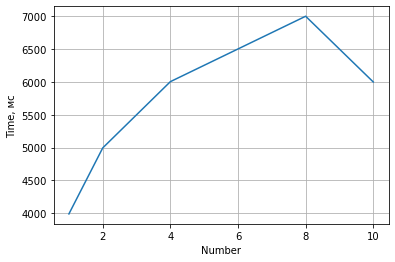

In [19]:
%run 6.py

## Multiprocessing

**7.** (2) Опишите в файле `multiprocessing_explained.md`, как работает модуль `multiprocessing` и как он делит память между процессами.

Библиотека `multiprocessing` позволяет организовать параллелизм вычислений за счет создания подпроцессов. Т.к. каждый процесс выполняется независимо от других, этот *метод параллелизма позволяет избежать проблем с GIL*. Предоставляемый библиотекой API схож с тем, что есть в `threading`, хотя есть уникальные вещи. 

Создание процесса происходит поутем создания объекта класса `Process`. Аргументы конструктора аналогичны тем, что есть в конструкторе `Thread`. В том числе аргумент `daemon` позволяет создавать служебные процессы. Служебные процессы завершаются вместе с родительским процессом и не могут порождать свои подпроцессы.

**8.** (2) Опишите в файле `synchronization_primitives.md` , что такое примитивы синхронизации. Там же опишите, что такое мьютекс (Mutex) и как работает `multiprocessing.Lock()`

*Как правильно приказать компьютеру синхронизировать потоки?* 

Для этого используются **примитивы синхронизации** — простые программные механизмы, обеспечивающие гармоничное взаимодействие потоков друг с другом. Они обычно строятся с использованием механизмов более низкого уровня (например, атомарных операций, барьеров памяти, спин-блоков, переключателей контекста и т. д.).

Mutex, событие, условные переменные и семафоры-все это примитивы синхронизации. Так же как и общие и эксклюзивные замки.

Условно классический **мьютекс(Mutex)** можно представить в виде переменной, которая может находиться в двух состояниях: в заблокированном и в незаблокированном. При входе в свою критическую секцию поток вызывает функцию перевода мьютекса в заблокированное состояние, при этом поток блокируется до освобождения мьютекса, если другой поток уже владеет им. При выходе из критической секции поток вызывает функцию перевода мьютекса в незаблокированное состояние. В случае наличия нескольких заблокированных по мьютексу потоков во время разблокировки мьютекса выбирается произвольный из них.

одновременный доступ к общим данным должен быть защищен блокировкой, чтобы избежать проблем с синхронизацией.

**9.** (3) Перепишите программу из п.5 с использованием `multiprocessing` и постройте такие же графики, как в п.6. Ускорилась ли теперь программа? *На данном этапе необязательно сохранять результат подсчета и выдавать его. Главное, чтобы были расчеты.*

**10.** (3) Организуйте передачу результатов подсчета между процессорами с помощью `Queue` и с помощью `Pipe`. Добейтесь того, чтобы на выходе Ваша программа могла вывести скалярное произведение.

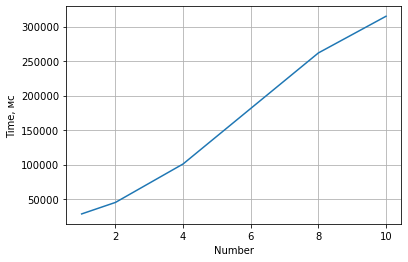

In [24]:
%run 10.py

## Pool

**11.** (3) Перепишите скалярное произведение векторов через `Pool` (подсказка: используйте `pool.map` и передавайте ему `zip` из двух векторов).